In [32]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [33]:
import numpy as np

from cev.test_cases.confusion import (
    case1,
    case2,
    case3,
    case4,
    case5,
    plot_confusion,
)

from cev.test_cases.utils import plot

np.random.seed(42)

### Confusion 1

- Case: 5 equal sized groups, well separated
- Expected: no confusion

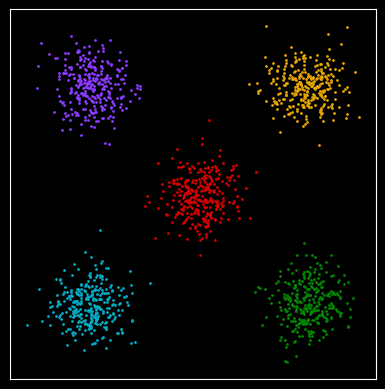

In [34]:
plot(case1())

### Confusion 2

- Case: 5 equal sized groups, 2 mixed
- Expected: confusion with last two groups

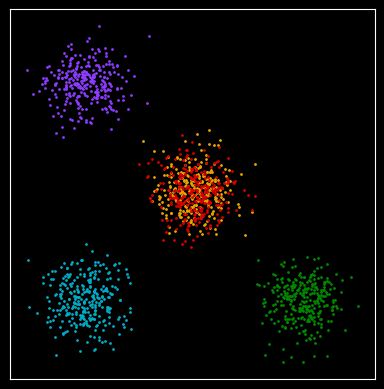

In [35]:
plot(case2())

### Confusion 3

- Case: 5 groups of various sizes, small group intermixed with larger
- Expected: smaller group should be confused with larger mixed group

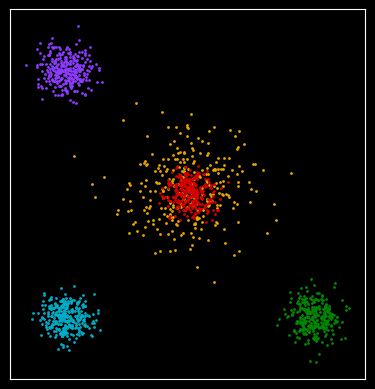

In [36]:
plot(case3())

### Confusion 4

- Case: 5 groups of various sizes, small group intermixed with larger
- Expected: smaller group should be confused with larger mixed group

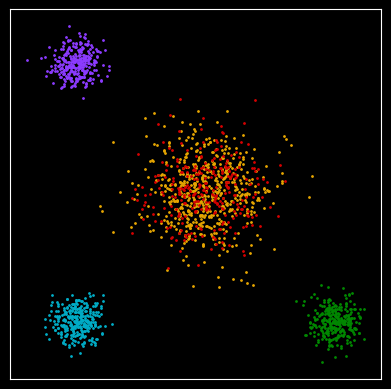

In [37]:
plot(case4())

### Confusion 5

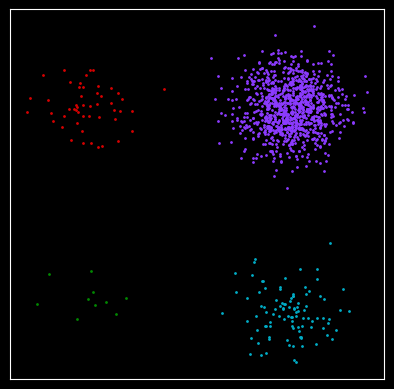

In [38]:
plot(case5())

## Testing


In [39]:
import functools

from cev.test_cases.metrics import fixed_k, dynamic_k

def run(metrics):
    for case in [case1, case2, case3, case4, case5]:
        plot_confusion(case(), metrics)

#### Fixed _k_

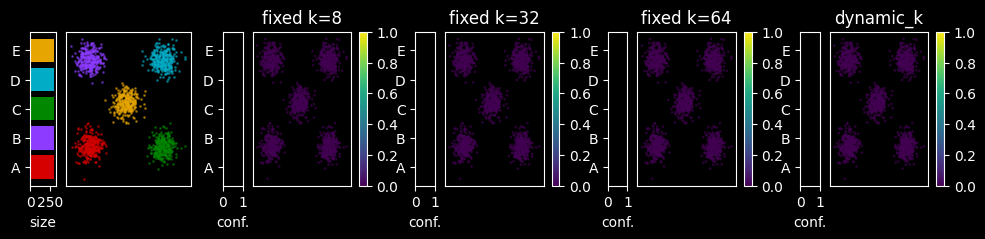

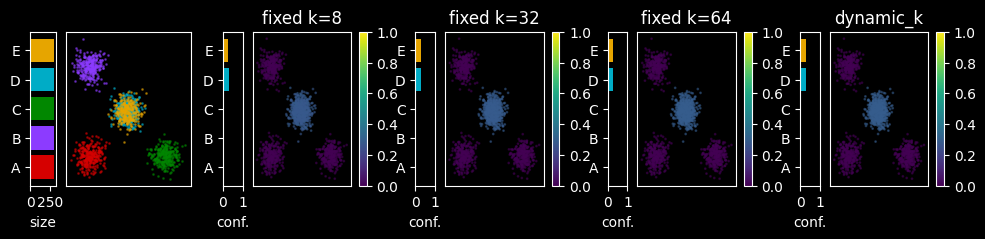

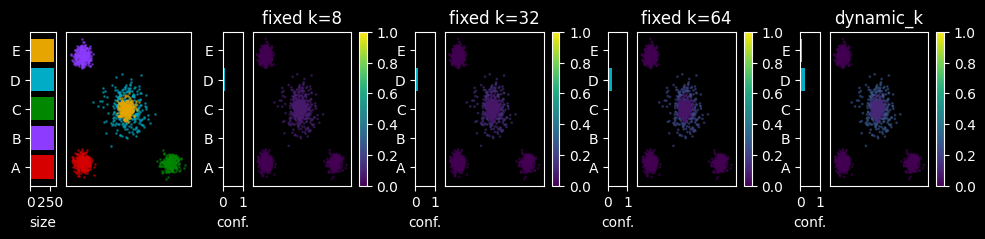

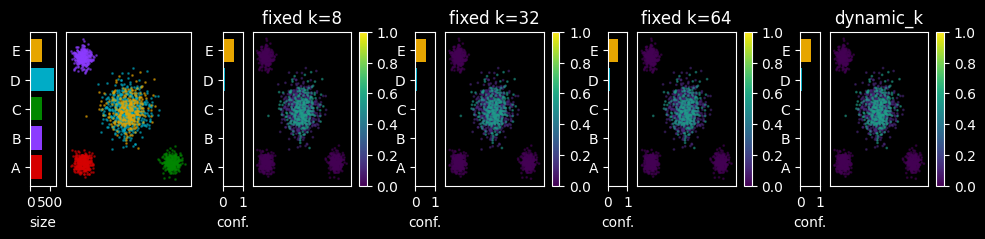

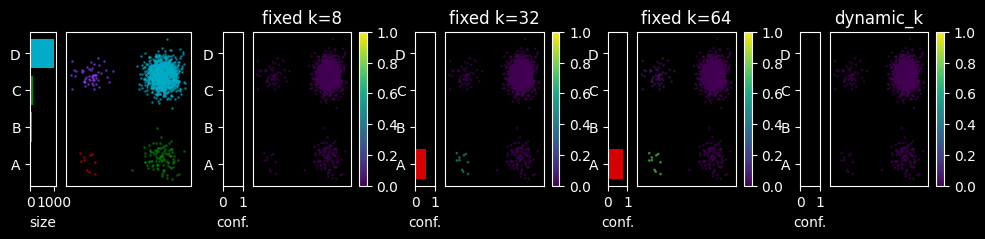

In [43]:
import matplotlib.pyplot as plt
plt.style.use('dark_background')


run([
    ("fixed k=8", functools.partial(fixed_k, k=8)),
    ("fixed k=32", functools.partial(fixed_k, k=32)),
    ("fixed k=64", functools.partial(fixed_k, k=64)),
    ("dynamic_k", dynamic_k),
])